In [1]:
import re
import os
import glob
import zipfile
import requests
from urllib.request import urlretrieve
import json
import pandas as pd
import numpy as np
import calendar
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Necessary metadata

article_id = 14096681 
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figsharerainfall/"

In [3]:
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text) 
files = data["files"]     
files

[{'id': 26579150,
  'name': 'daily_rainfall_2014.png',
  'size': 58863,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e'},
 {'id': 26579171,
  'name': 'environment.yml',
  'size': 192,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34'},
 {'id': 26586554,
  'name': 'README.md',
  'size': 5422,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c'},
 {'id': 26766812,
  'name': 'data.zip',
  'size': 814041183,
  'is_link_only': False,
  'download_url': 'https://ndownloader.figshare.com/files/26766812',
  'supplied_md5': 'b517383f76e77bd03755a63a8f

In [4]:
%%time
files_to_dl = ["data.zip"]
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True)
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: total: 4.81 s
Wall time: 28.6 s


In [5]:
%%time
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

CPU times: total: 17.2 s
Wall time: 18.6 s


- Here I am combining data CSVs into a single CSV, and add an extra column "model". 
- **Difficulties**: I initially tried one regex expression and wait for a long time and got error, so after that, I used an online tool to test regex expression before put it into the code here.

In [6]:
%%time

import pandas as pd
# use_cols = ["time", "lat_min", "lat_max", "lon_min","lon_max","rain (mm/day)"]
files = glob.glob('figsharerainfall/*.csv')
# exlude files if exist
if 'figshareaustralia\\observed_daily_rainfall_SYD.csv' in files:
    files.remove('figshareaustralia\\observed_daily_rainfall_SYD.csv')
if "figsharerainfall\\combined_data.csv" in files:
    files.remove('figsharerainfall\\combined_data.csv')

df = pd.concat((pd.read_csv(file, index_col=0)
                .assign(model=re.findall(r'[^=\\]+(?=\_daily)', file)[0])
                for file in files)
              )
df.to_csv("figsharerainfall/combined_data.csv")

CPU times: total: 6min 47s
Wall time: 7min


- **Difficulties**: My computer's C drive doesn't have a lot of space left, I have to delete some of my big files during the process. And Jupyter lab crashed once and showed "Aw, Snap!"

In [7]:
df=df
df

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-36.250000,-35.00000,140.625,142.500,3.293256e-13,ACCESS-CM2
1889-01-02 12:00:00,-36.250000,-35.00000,140.625,142.500,0.000000e+00,ACCESS-CM2
1889-01-03 12:00:00,-36.250000,-35.00000,140.625,142.500,0.000000e+00,ACCESS-CM2
1889-01-04 12:00:00,-36.250000,-35.00000,140.625,142.500,0.000000e+00,ACCESS-CM2
1889-01-05 12:00:00,-36.250000,-35.00000,140.625,142.500,1.047658e-02,ACCESS-CM2
...,...,...,...,...,...,...
2014-12-27 12:00:00,-30.157068,-29.21466,153.125,154.375,5.543748e-01,TaiESM1
2014-12-28 12:00:00,-30.157068,-29.21466,153.125,154.375,7.028577e+00,TaiESM1
2014-12-29 12:00:00,-30.157068,-29.21466,153.125,154.375,2.347570e-01,TaiESM1


## Python EDA
### Changing the dtype

In [8]:
df.shape

(62513863, 6)

In [9]:
%%time
df.value_counts()

CPU times: total: 1min 15s
Wall time: 1min 17s


lat_min  lat_max  lon_min   lon_max   rain (mm/day)  model        
-30.625  -29.375  141.5625  143.4375  0.000000       ACCESS-ESM1-5    15271
-31.875  -30.625  141.5625  143.4375  0.000000       ACCESS-ESM1-5    13850
-30.625  -29.375  143.4375  145.3125  0.000000       ACCESS-ESM1-5    13615
-31.875  -30.625  143.4375  145.3125  0.000000       ACCESS-ESM1-5    12638
-33.125  -31.875  141.5625  143.4375  0.000000       ACCESS-ESM1-5    12112
                                                                      ...  
-34.000  -33.000  148.7500  150.0000  0.000702       GFDL-CM4             1
                                      0.000704       GFDL-CM4             1
                                                     GFDL-CM4             1
                                                     GFDL-CM4             1
-29.900  -29.100  152.7250  153.5250  199.089043     FGOALS-f3-L          1
Length: 55839634, dtype: int64

In [10]:
def df_uniques(df):
    result = {}
    for x in df.columns:
        result[df[x].name] = df[x].unique().tolist()[0:5]
    return result

def summarytable(df):
    result = {}
    result["Not Null Count"] = df.notnull().sum()
    result["Null Count"] = df.isnull().sum()
    result["Number of Unique Values"] = df.nunique()
    result["Some Unique Values"] = df_uniques(df)
    result["Types"] = df.dtypes
    result_df = pd.DataFrame(result)
    return result_df

In [11]:
%%time
summarytable(df)

CPU times: total: 1min 3s
Wall time: 1min 10s


,Not Null Count,Null Count,Number of Unique Values,Some Unique Values,Types
lat_min,59248543,3265320,84,"[-36.25, -35.0, -33.75, -32.5, -31.25]",float64
lat_max,62467843,46020,87,"[-35.0, -33.75, -32.5, -31.25, -30.0]",float64
lon_min,59248543,3265320,78,"[140.625, 142.5, 144.375, 146.25, 148.125]",float64
lon_max,62467843,46020,79,"[142.5, 144.375, 146.25, 148.125, 150.0]",float64
rain (mm/day),59294563,3219300,41184553,"[3.293256237400178e-13, 0.0, 0.010476575562279...",float64
model,62513863,0,28,"[ACCESS-CM2, ACCESS-ESM1-5, AWI-ESM-1-1-LR, BC...",object


- Here I changed the dtype of the data from float64 to float32

In [12]:
df_32 = df.astype({"lat_min": np.float32, "lat_max": np.float32, "lon_min": np.float32, "lon_max": np.float32, "rain (mm/day)": np.float32})

In [13]:
%%time
df_32.value_counts()

CPU times: total: 1min 26s
Wall time: 1min 38s


lat_min  lat_max  lon_min     lon_max     rain (mm/day)  model        
-30.625  -29.375  141.562500  143.437500  0.000000       ACCESS-ESM1-5    15271
-31.875  -30.625  141.562500  143.437500  0.000000       ACCESS-ESM1-5    13850
-30.625  -29.375  143.437500  145.312500  0.000000       ACCESS-ESM1-5    13615
-31.875  -30.625  143.437500  145.312500  0.000000       ACCESS-ESM1-5    12638
-33.125  -31.875  141.562500  143.437500  0.000000       ACCESS-ESM1-5    12112
                                                                          ...  
-34.000  -33.000  148.750000  150.000000  0.000853       GFDL-CM4             1
                                                         GFDL-CM4             1
                                          0.000855       GFDL-CM4             1
                                          0.000856       GFDL-CM4             1
-29.900  -29.100  152.725006  153.524994  199.089050     FGOALS-f3-L          1
Length: 55829067, dtype: int64

In [14]:
%%time
summarytable(df_32)

CPU times: total: 46.9 s
Wall time: 48 s


,Not Null Count,Null Count,Number of Unique Values,Some Unique Values,Types
lat_min,59248543,3265320,69,"[-36.25, -35.0, -33.75, -32.5, -31.25]",float32
lat_max,62467843,46020,74,"[-35.0, -33.75, -32.5, -31.25, -30.0]",float32
lon_min,59248543,3265320,77,"[140.625, 142.5, 144.375, 146.25, 148.125]",float32
lon_max,62467843,46020,78,"[142.5, 144.375, 146.25, 148.125, 150.0]",float32
rain (mm/day),59294563,3219300,40192331,"[3.293256238458969e-13, 0.0, 0.010476575233042...",float32
model,62513863,0,28,"[ACCESS-CM2, ACCESS-ESM1-5, AWI-ESM-1-1-LR, BC...",object


- Seems like changing the `dytype` doesn't influence the processing speed a lot.

### Plot data with different dtype / load only necessary columns

In [15]:
df['log_rain'] = np.log1p(df['rain (mm/day)'])

In [16]:
df_32_2 = df.astype({"log_rain": np.float32})

In [17]:
df_onlyrain = df[['log_rain', "model"]].copy()

CPU times: total: 30.3 s
Wall time: 32.8 s


Text(0.5, 1.0, 'Distributions of values for amount of rain')

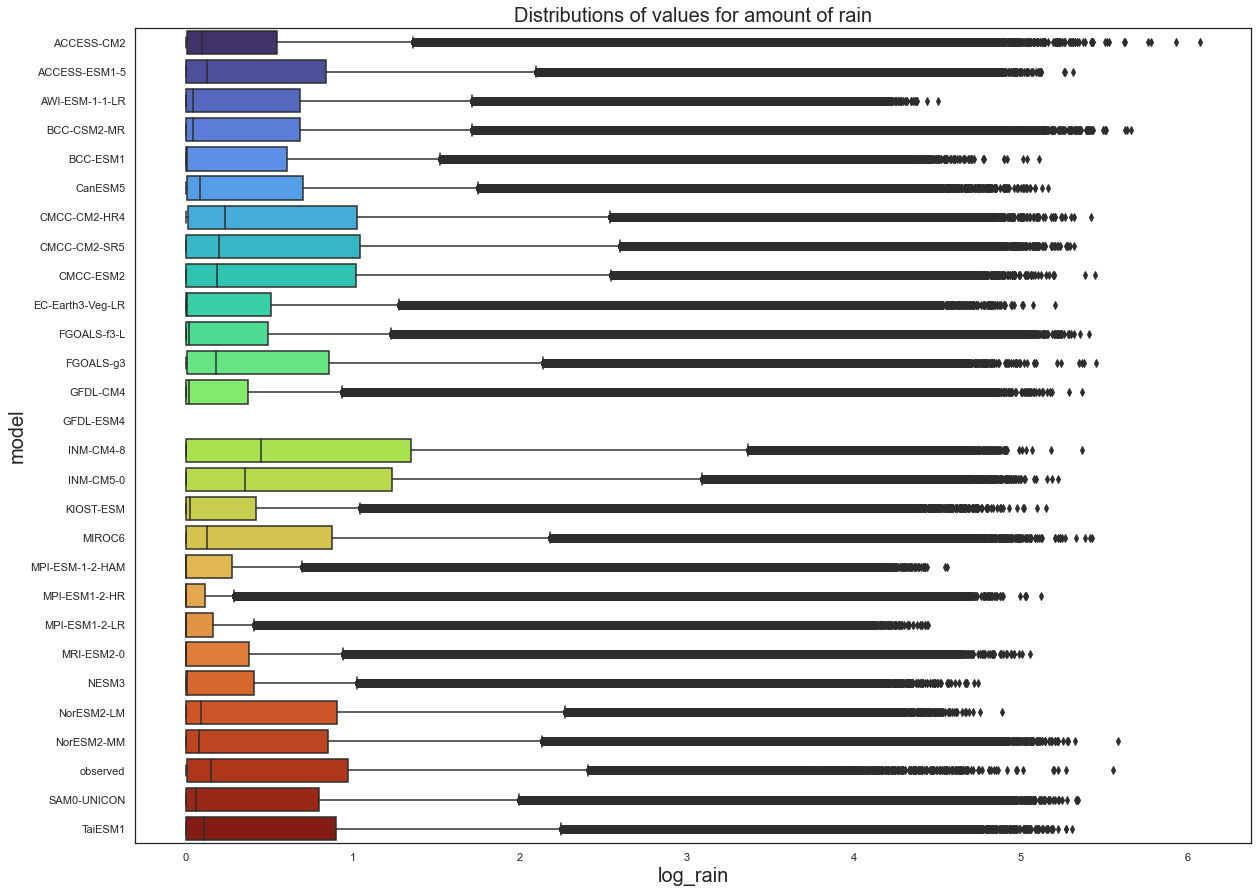

In [18]:
%%time
sns.set(rc={'figure.figsize':(20,15),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
sns.boxplot(data = df, x="log_rain", y="model", palette='turbo').set_title('Distributions of values for amount of rain'); 

CPU times: total: 21.1 s
Wall time: 21.4 s


Text(0.5, 1.0, 'Distributions of values for amount of rain')

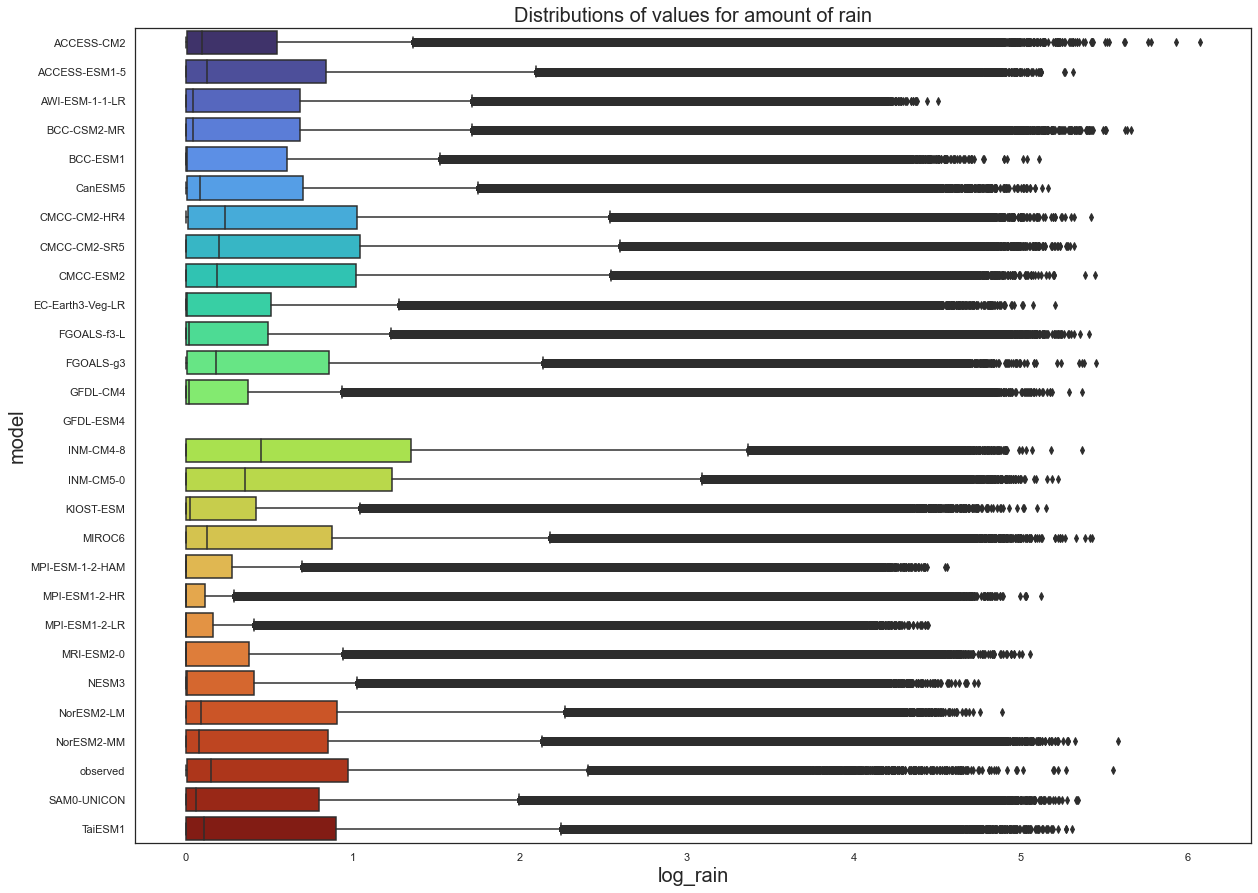

In [19]:
%%time
sns.set(rc={'figure.figsize':(20,15),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
sns.boxplot(data = df_32_2, x="log_rain", y="model", palette='turbo').set_title('Distributions of values for amount of rain'); 

CPU times: total: 21.2 s
Wall time: 21.6 s


Text(0.5, 1.0, 'Distributions of values for amount of rain')

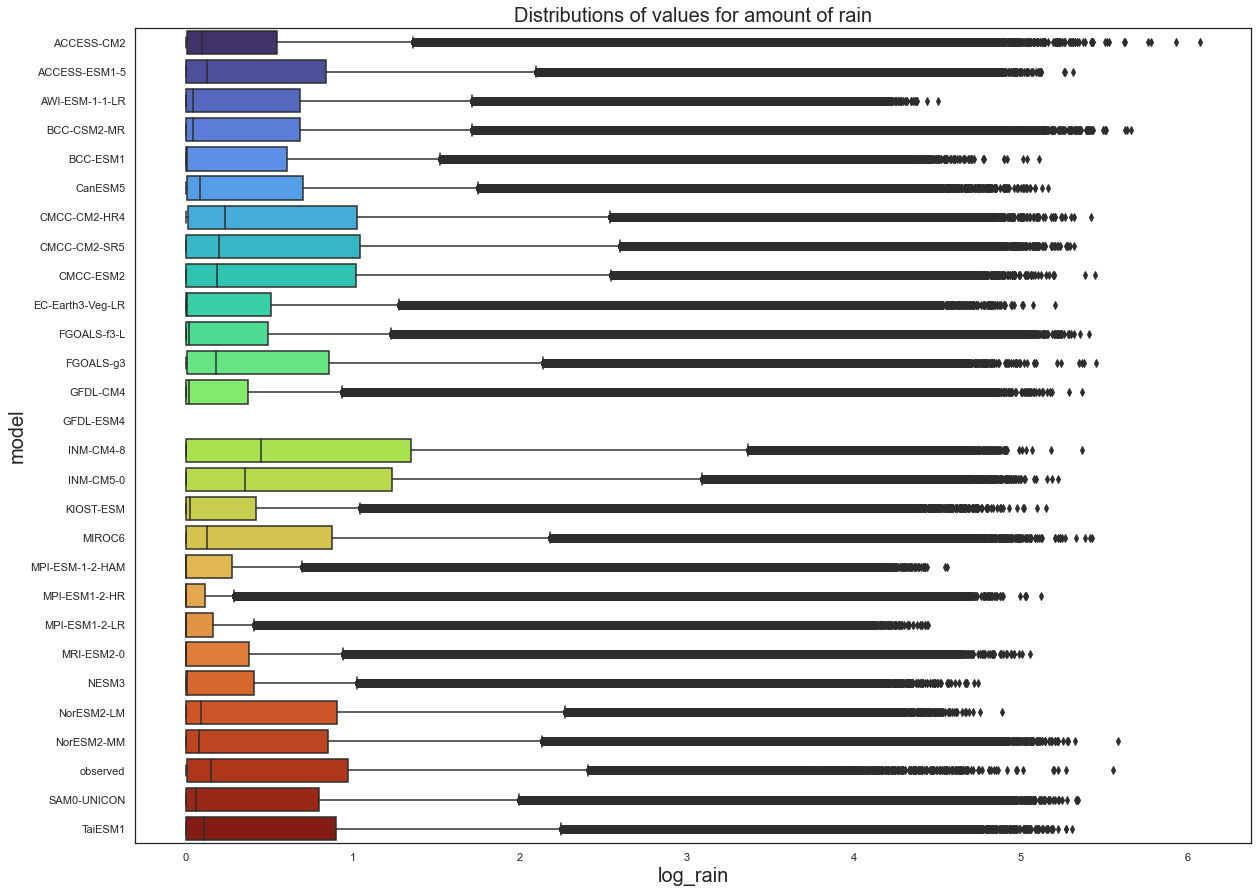

In [20]:
%%time
sns.set(rc={'figure.figsize':(20,15),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white") 
sns.boxplot(data = df_onlyrain, x="log_rain", y="model", palette='turbo').set_title('Distributions of values for amount of rain'); 

- As we can see here, the processing time again doesn't decrease a lot.

## R EDA

In [21]:
%load_ext rpy2.ipython

C:\Users\Administrator\miniconda3\envs\525_2022\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


I am using the parquet file here because when we do R EDA through dplyr, the parquet file can perform pretty fast, much better than directly importing it from python. And also, we learned about the syntax of parquet during the lecture so it is easier for us to use it.

In [22]:
df.to_parquet("figsharerainfall/combined_data_partition.parquet",partition_cols=['model'])

In [23]:
# if we just use str method, the speed is relatively slow
%%time
%%R
suppressMessages(library(data.table))
suppressMessages(library(arrow, warn.conflicts = FALSE))
suppressMessages(library(dplyr, warn.conflicts = FALSE))
ds <- open_dataset("figsharerainfall/combined_data_partition.parquet")
ds1 <- collect(ds)
str(ds1)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (761727524.py, line 5)

In [ ]:
# if we use dplyr package and collect(), the speed is relatively fast
%%time
%%R
ds2 <- ds%>%
     group_by(model) %>% 
     summarise(
         total=n(), 
         not_null_rain = sum(!is.na(`rain (mm/day)`)),
         min = min(`rain (mm/day)`),
         mean = mean(`rain (mm/day)`),
         max = max(`rain (mm/day)`),          
     ) %>% 
    collect()
ds2